In [67]:
import pandas as pd
import numpy as np
from pathlib import Path

In [68]:
file = Path('Task 3 and 4_Loan_Data.csv')
df = pd.read_csv(file)
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [69]:
def calculate_log_likelihood(df, boundaries):

    total_ll = 0
    
    for i in range(len(boundaries) - 1):
        mask = (df['fico_score'] >= boundaries[i]) & (df['fico_score'] < boundaries[i+1])
        ni = mask.sum()
        
        if ni == 0:
            continue
        ki = df.loc[mask, 'default'].sum()
        pi = ki / ni
        
        # Avoid log(0)
        if pi == 0:
            pi = 1e-10
        elif pi == 1:
            pi = 1 - 1e-10
        
        ll_i = ki * np.log(pi) + (ni - ki) * np.log(1 - pi)
        total_ll += ll_i
    
    return total_ll



In [70]:
def optimize_boundaries_greedy(df, n_buckets, n_iterations=50):
  
    boundaries = [df['fico_score'].quantile(i/n_buckets) for i in range(n_buckets + 1)]
    current_ll = calculate_log_likelihood(df, boundaries)
    
    print(f"Initial LL: {current_ll:.2f}")
    print(f"Initial Boundaries: {[f'{b:.0f}' for b in boundaries]}")
    
    for iteration in range(n_iterations):
        improved = False
        
        for i in range(1, len(boundaries) - 1):
            original_value = boundaries[i]
            
            for delta in [-10, -5, -2, -1, 1, 2, 5, 10]:
                test_boundaries = boundaries.copy()
                new_value = original_value + delta
            
                if new_value <= boundaries[i-1]:
                    continue
                if new_value >= boundaries[i+1]:
                    continue
                
                test_boundaries[i] = new_value
                test_ll = calculate_log_likelihood(df, test_boundaries)
                
                if test_ll > current_ll:
                    boundaries = test_boundaries
                    current_ll = test_ll
                    improved = True
                    break
            
            if improved:
                break
        
        if not improved:
            print(f"Converged after {iteration} iterations")
            break
    
    print(f"\nFinal LL: {current_ll:.2f}")
    return boundaries


In [73]:
# the best LL is with 3 buckets, however the furst bucket will have only 4 people 
#which is not representative

import matplotlib.pyplot as plt

def calculate_aic(df, boundaries):
    ll = calculate_log_likelihood(df, boundaries)
    k = len(boundaries) - 1
    aic = 2 * k - 2 * ll
    return aic, ll

def calculate_bic(df, boundaries):
    ll = calculate_log_likelihood(df, boundaries)
    k = len(boundaries) - 1
    n = len(df)
    bic = k * np.log(n) - 2 * ll
    return bic, ll

# Test all options
results = []

for n in [3, 4, 5, 6, 7, 8, 10]:
    print(f"\n{'='*70}")
    print(f"Testing {n} buckets")
    print(f"{'='*70}")
    
    boundaries = optimize_boundaries_greedy(df, n_buckets=n, n_iterations=30)
    
    aic, ll = calculate_aic(df, boundaries)
    bic, _ = calculate_bic(df, boundaries)
    
    results.append({'n_buckets': n, 'll': ll, 'aic': aic,'bic': bic,'boundaries': boundaries})
    
    print(f"LL: {ll:.2f}, AIC: {aic:.2f}, BIC: {bic:.2f}")

results_df = pd.DataFrame(results)

# Find optimal
best_aic = results_df.loc[results_df['aic'].idxmin()]
best_bic = results_df.loc[results_df['bic'].idxmin()]

print("\n" + "="*70)
print("SUMMARY")
print(results_df)

print(f"\nBest by AIC: {best_aic['n_buckets']} buckets")
print(f"Best by BIC: {best_bic['n_buckets']} buckets")

# Typically use AIC or BIC choice
optimal_n = int(best_bic['n_buckets'])
optimal_boundaries = best_bic['boundaries']

print(f"\nFINAL CHOICE: {optimal_n} buckets")
print(f"   Boundaries: {[f'{b:.0f}' for b in optimal_boundaries]}")

df['bucket'] = pd.cut(df['fico_score'], bins=optimal_boundaries, labels=False, include_lowest=True)


Testing 3 buckets
Initial LL: -4366.09
Initial Boundaries: ['408', '612', '664', '850']
Converged after 11 iterations

Final LL: -4320.88
LL: -4320.88, AIC: 8647.76, BIC: 8669.39

Testing 4 buckets
Initial LL: -4338.85
Initial Boundaries: ['408', '597', '638', '679', '850']
Converged after 12 iterations

Final LL: -4305.10
LL: -4305.10, AIC: 8618.20, BIC: 8647.04

Testing 5 buckets
Initial LL: -4314.77
Initial Boundaries: ['408', '587', '623', '653', '688', '850']
Converged after 22 iterations

Final LL: -4256.60
LL: -4256.60, AIC: 8523.21, BIC: 8559.26

Testing 6 buckets
Initial LL: -4280.24
Initial Boundaries: ['408', '580', '612', '638', '664', '696', '850']
Converged after 13 iterations

Final LL: -4254.31
LL: -4254.31, AIC: 8520.62, BIC: 8563.88

Testing 7 buckets
Initial LL: -4288.11
Initial Boundaries: ['408', '573', '604', '628', '649', '672', '702', '850']
Converged after 21 iterations

Final LL: -4242.74
LL: -4242.74, AIC: 8499.48, BIC: 8549.96

Testing 8 buckets
Initial LL:

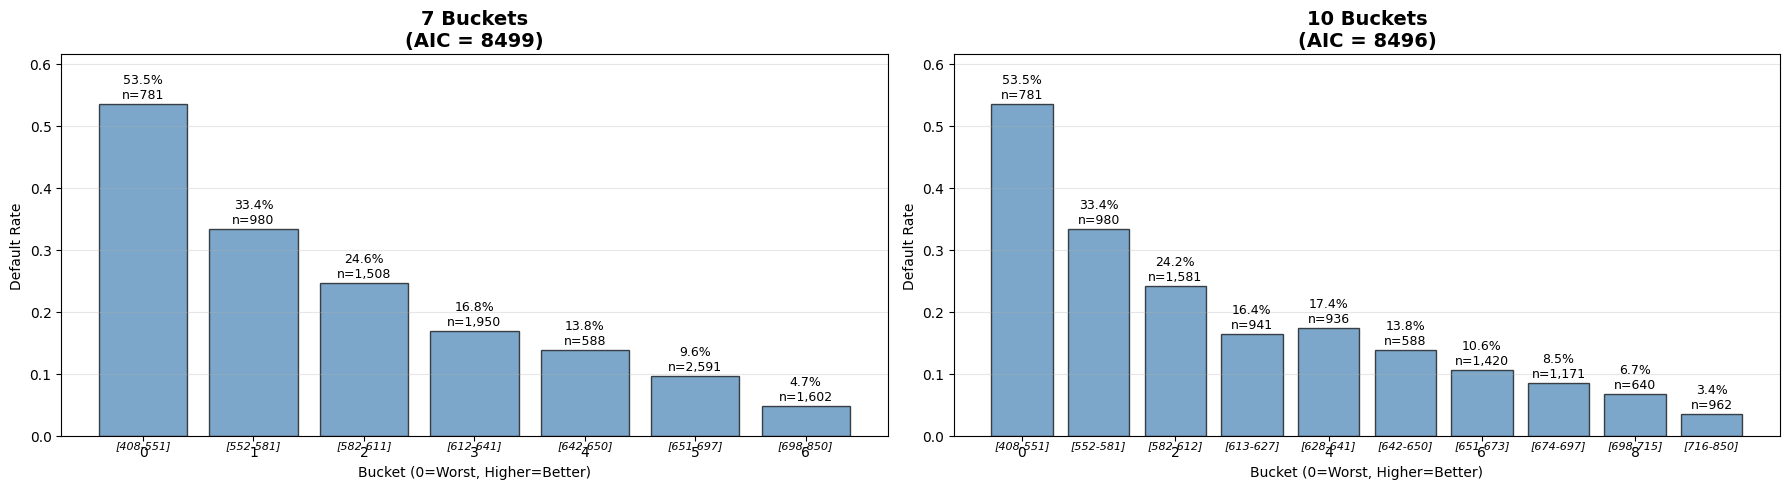

In [74]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(18, 5))

for idx, n in enumerate([7,10]):
    # Get boundaries
    boundaries = results_df[results_df['n_buckets'] == n]['boundaries'].values[0]
    df[f'bucket_{n}'] = pd.cut(df['fico_score'], bins=boundaries, labels=False, include_lowest=True)
    
    # Calculate stats per bucket
    bucket_stats = df.groupby(f'bucket_{n}').agg({'default': ['count', 'sum', 'mean'],
        'fico_score': ['min', 'max']})
    
    bucket_stats.columns = ['count', 'defaults', 'default_rate', 'fico_min', 'fico_max']
    
    ax = axes[idx]
    bars = ax.bar(bucket_stats.index, bucket_stats['default_rate'], alpha=0.7, color='steelblue', edgecolor='black')
    
    ax.set_title(f'{n} Buckets\n(AIC = {results_df[results_df["n_buckets"]==n]["aic"].values[0]:.0f})', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Bucket (0=Worst, Higher=Better)')
    ax.set_ylabel('Default Rate')
    ax.set_ylim(0, bucket_stats['default_rate'].max() * 1.15)
    ax.grid(axis='y', alpha=0.3)
    

    for i, (bucket_id, row) in enumerate(bucket_stats.iterrows()):
        ax.text(i, row['default_rate'] + 0.01, f"{row['default_rate']:.1%}\nn={int(row['count']):,}", ha='center', fontsize=9)
        
        # Add FICO range below
        ax.text(i, -0.02, f"[{row['fico_min']:.0f}-{row['fico_max']:.0f}]", ha='center', fontsize=8, style='italic')

plt.tight_layout()
plt.show()

In [47]:
#The best one is 7 Buckets:
"""
With 10 Buckets 3 and 4 are NOT monotonic which means people with higher FICO are more likely to default?
This doesn't make sense. SO the final"""
# ['408', '551', '581', '611', '641', '650', '697', '850']

"\n- Clear risk gradient\n- Good separation between adjacent buckets\n- Reasonable sample sizes (all >650 except outlier)\n- Still has 2-person outlier, but it's tiny enough to ignore/merge"

In [78]:
boundaries_7 = [408, 551, 581, 611, 641, 650, 697, 850]
boundaries_final = boundaries_7
df['bucket'] = pd.cut(df['fico_score'], bins=boundaries_final, labels=False, include_lowest=True)

# Create rating system
rating_labels = ['G', 'F', 'E', 'D', 'C', 'B', 'A']
df['rating'] = df['bucket'].map({i: rating_labels[i] for i in range(7)})

# Final summary
print("\n" + "="*70)
print("FINAL MORTGAGE CREDIT RATING SYSTEM")
print("="*70)

rating_summary = df.groupby('rating').agg({
    'fico_score': ['min', 'max', 'mean', 'count'],
    'default': ['sum', 'mean']
})
rating_summary.columns = ['FICO_Min', 'FICO_Max', 'FICO_Mean', 'Count', 'Defaults', 'Default_Rate']
print(rating_summary)


FINAL MORTGAGE CREDIT RATING SYSTEM
        FICO_Min  FICO_Max   FICO_Mean  Count  Defaults  Default_Rate
rating                                                               
A            698       850  728.506866   1602        76      0.047441
B            651       697  672.321883   2591       250      0.096488
C            642       650  646.093537    588        81      0.137755
D            612       641  626.765641   1950       328      0.168205
E            582       611  597.198939   1508       371      0.246021
F            552       581  567.955102    980       327      0.333673
G            408       551  521.453265    781       418      0.535211
